In [2]:
from ultralytics import YOLO
from PIL import Image
from kitchen.visualization import draw_bboxes_xyxy
from kitchen.visual_tasks import crop_image
from kitchen.yolo import yolo_to_bbox_xyxy
from kitchen.file_tools import read_lines
import cv2
from ultralytics.utils.plotting import Annotator, colors




In [ ]:
# image = Image.open("data/detection/train/images/img_000011.jpg").convert("RGB")
# label = read_lines("data/detection/train/labels/img_000011.txt")
# bboxes = [yolo_to_bbox_xyxy(yolo_str, image.height, image.width) for yolo_str in label]
# bboxes
# draw_bboxes_xyxy(image, bboxes)

In [21]:
# detector = YOLO("./models/yolo11m.pt")
# dish_classifier = YOLO("./models/YOLO11m-cls.pt")
# tray_classifier = YOLO("./models/YOLO11m-cls.pt")

detector = YOLO("models/detector/best.pt")
dish_classifier = YOLO("models/dish_classifier/best.pt")
tray_classifier = YOLO("models/tray_classifier/best.pt")

In [4]:
# detector.train(data="./data/detection/dataset.yaml", epochs=10, batch=10)
# dish_classifier.train(data="./data/classification/dish", epochs=1, batch=10)
# tray_classifier.train(data="./data/classification/tray", epochs=1, batch=10)

Pipeline:
- Cut video into frames
- Detect dishes and trays
- Further classify dishes and trays

In [25]:
video_path = "data/first.mp4"
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter("data/tracking.mp4", cv2.VideoWriter_fourcc(*"MJPG"), fps, (width, height))

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [ ]:
dish_classifier_path = "runs/classify/train7/weights/best.pt"
all_tracked = detector.track(
    "data/first.mp4", 
    show=False, 
    tracker="configs/trackers/botsort.yaml", 
    conf=0.2, 
    iou=0.5,
)


0: 384x640 2 dishs, 1 tray, 122.6ms
Speed: 2.3ms preprocess, 122.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 224x224 empty 0.84, not_empty 0.12, kakigori 0.04, 30.5ms
Speed: 1.2ms preprocess, 30.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 empty 0.86, not_empty 0.10, kakigori 0.04, 17.6ms
Speed: 1.0ms preprocess, 17.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 empty 0.94, not_empty 0.06, kakigori 0.00, 20.4ms
Speed: 1.1ms preprocess, 20.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


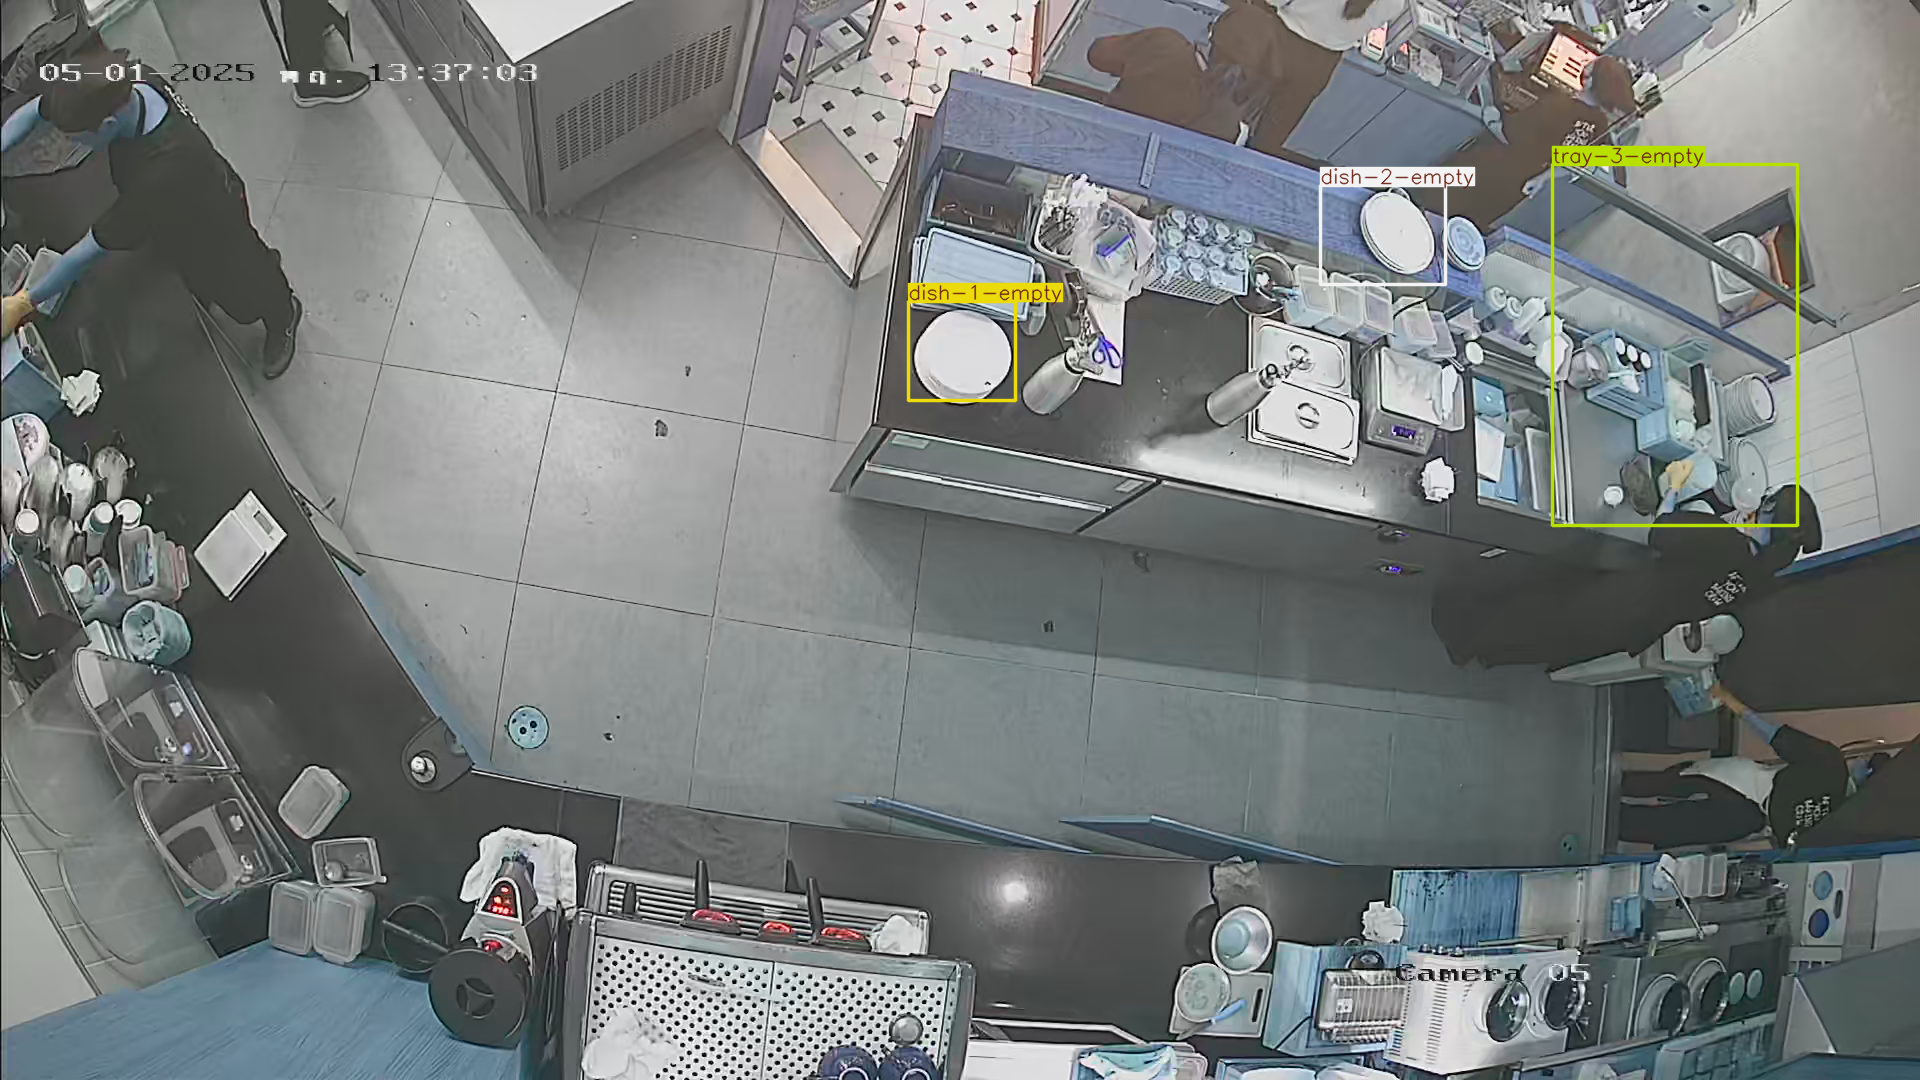

In [18]:
import numpy as np
from PIL import Image

ret, frame = cap.read()

image = Image.fromarray(frame)
annotator = Annotator(frame, line_width=2, font_size=20)

results = detector.track(source=frame, conf=0.2, iou=0.5)
boxes = results[0].boxes.xyxy
classes = results[0].boxes.cls.int()
names = [detector.names[i.item()] for i in  classes]
track_ids = results[0].boxes.id.int().cpu().tolist()

# Classify empty, kakigori, not empty
for bbox, cls, name, track_id in zip(boxes, classes, names, track_ids):
    cropped = crop_image(frame, bbox)

    if cls == 0:
        subclass = dish_classifier(cropped)
        subclass_name = dish_classifier.names[subclass[0].probs.top1]
    elif cls == 1:
        subclass == tray_classifier(cropped)
        subclass_name = tray_classifier.names[subclass[0].probs.top1]
    
    annotator.box_label(box=bbox, color = colors(int(track_id), True), label=f"{name}-{track_id}-{subclass_name}")


cropped = crop_image(frame, bbox)

# image_array = np.array(frame)
Image.fromarray(frame)

In [26]:
while True:
    ret, frame = cap.read()

    if not ret:
        print("Done")
        break

    annotator = Annotator(frame, line_width=2, font_size=20)
    results = detector.track(frame, persist=True, conf=0.2, iou=0.5)

    if results[0].boxes.is_track and results[0].boxes is not None:
        boxes = results[0].boxes.xyxy
        classes = results[0].boxes.cls.int()
        names = [detector.names[i.item()] for i in  classes]
        track_ids = results[0].boxes.id.int().cpu().tolist()

        # Classify empty, kakigori, not empty
        for bbox, cls, name, track_id in zip(boxes, classes, names, track_ids):
            cropped = crop_image(frame, bbox)

            if cls == 0:
                subclass = dish_classifier(cropped)
                subclass_name = dish_classifier.names[subclass[0].probs.top1]
            elif cls == 1:
                subclass == tray_classifier(cropped)
                subclass_name = tray_classifier.names[subclass[0].probs.top1]
            
            annotator.box_label(box=bbox, color = colors(int(track_id), True), label=f"{name}-{track_id}-{subclass_name}")

    out.write(frame)

    # if cv2.waitKey(1) & 0xFF == ord("q"):
    #     break

out.release()
cap.release()


0: 384x640 3 dishs, 1 tray, 182.0ms
Speed: 4.2ms preprocess, 182.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 224x224 empty 0.95, not_empty 0.04, kakigori 0.01, 31.0ms
Speed: 1.4ms preprocess, 31.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 empty 0.62, not_empty 0.29, kakigori 0.09, 28.5ms
Speed: 1.1ms preprocess, 28.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 empty 0.76, not_empty 0.21, kakigori 0.04, 18.5ms
Speed: 1.2ms preprocess, 18.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 not_empty 0.66, empty 0.24, kakigori 0.10, 19.1ms
Speed: 0.9ms preprocess, 19.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 384x640 9 dishs, 1 tray, 107.0ms
Speed: 1.2ms preprocess, 107.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 224x224 empty 0.86, not_empty 0.12, kakigori 0.02, 22.3ms
Speed: 1.7ms preprocess, 22.3ms 